1. PREPROCESS DATA PIPELINE / CLEAN DATA 

In [1]:
import yfinance as yf
import mplfinance as mpf 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
ticker = "BX"
data = yf.download(ticker, start="2021-01-01", end="2024-01-1")
data.reset_index(drop = True, inplace = True)
data.index = data.index + 1
data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,BX,BX,BX,BX,BX
1,54.185379,55.991557,53.505911,55.905550,3255800
2,54.021961,54.443401,53.540312,53.652124,2758600
3,53.032867,53.987563,52.697435,53.600524,5090700
4,54.383198,54.632623,53.617722,53.763935,2368300
5,54.099369,55.062660,53.333890,54.830440,2396700
...,...,...,...,...,...
749,126.349762,127.693599,124.947920,125.431315,3342400
750,127.007172,127.625917,126.011379,126.330422,2485000
751,128.205994,128.998754,126.243412,126.717144,3561200


In [3]:
macro = pd.read_csv("macro.csv")
macro.index = macro.index + 1
macro

,GDP,IPOs,M&A_Activities,FFR_rate
1,21058.379,118,435739,0.09
2,21058.379,118,435739,0.09
3,21058.379,118,435739,0.09
4,21058.379,118,435739,0.09
5,21058.379,118,435739,0.09
...,...,...,...,...
749,22960.600,7,299822,5.33
750,22960.600,7,299822,5.33
751,22960.600,7,299822,5.33
752,22960.600,7,299822,5.33


In [4]:
#Functions for technical indi
def RSI(data, period):
    delta = data["Close"].diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.ewm(span=period, adjust=False).mean()
    avg_loss = loss.ewm(span=period, adjust=False).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def EMA(data, period):
    return data["Close"].ewm(span = period, adjust = False).mean()

def MACD(data, short_period = 5, long_period = 17, signal_period = 9): 
    ema_short = EMA(data, short_period)
    ema_long = EMA(data, long_period)
    macd = ema_short - ema_long
    signal = macd.ewm(span=signal_period, adjust=False).mean()
    data["MACD"] = macd
    data["Signal"] = signal
    return data 

def Bollinger_Bands(data, period = 20, std_multiplier = 2):
    middle_band = data["Close"].rolling(window=period, min_periods=1).mean()
    std = data["Close"].rolling(window=period, min_periods=1).std()
    upper_band = middle_band + (std_multiplier * std)
    lower_band = middle_band - (std_multiplier * std)
    data["MiddleBand"] = middle_band
    data["UpperBand"] = upper_band
    data["LowerBand"] = lower_band
    data["MiddleBand"] = data["MiddleBand"].fillna(0)
    data["UpperBand"] = data["UpperBand"].fillna(0)
    data["LowerBand"] = data["LowerBand"].fillna(0)
    return data



In [5]:
rsi_values = RSI(data, period=14)
data["RSI"] = rsi_values
data = MACD(data, short_period=7, long_period=17, signal_period=9)
data = Bollinger_Bands(data, period=20, std_multiplier=2)

In [6]:
data.columns = data.columns.droplevel(1)
data

Price,Close,High,Low,Open,Volume,RSI,MACD,Signal,MiddleBand,UpperBand,LowerBand
1,54.185379,55.991557,53.505911,55.905550,3255800,NaN,0.000000,0.000000,54.185379,0.000000,0.000000
2,54.021961,54.443401,53.540312,53.652124,2758600,0.000000,-0.022697,-0.004539,54.103670,54.334778,53.872562
3,53.032867,53.987563,52.697435,53.600524,5090700,0.000000,-0.174572,-0.038546,53.746736,54.993945,52.499527
4,54.383198,54.632623,53.617722,53.763935,2368300,57.946883,-0.083427,-0.047522,53.905851,55.106728,52.704975
5,54.099369,55.062660,53.333890,54.830440,2396700,50.806614,-0.059767,-0.049971,53.944555,54.998849,52.890260
...,...,...,...,...,...,...,...,...,...,...,...
749,126.349762,127.693599,124.947920,125.431315,3342400,75.149325,5.668727,5.059965,114.358659,129.893933,98.823384
750,127.007172,127.625917,126.011379,126.330422,2485000,76.147004,5.652506,5.178474,115.548777,131.133090,99.964464
751,128.205994,128.998754,126.243412,126.717144,3561200,78.004994,5.651181,5.273015,116.755815,132.334687,101.176942
752,128.708725,129.095435,127.654913,128.099643,2087900,78.803882,5.563144,5.331041,117.807682,133.642671,101.972693


In [7]:
data_final = data.join(macro)
data_final

,Close,High,Low,Open,Volume,RSI,MACD,Signal,MiddleBand,UpperBand,LowerBand,GDP,IPOs,M&A_Activities,FFR_rate
1,54.185379,55.991557,53.505911,55.905550,3255800,NaN,0.000000,0.000000,54.185379,0.000000,0.000000,21058.379,118,435739,0.09
2,54.021961,54.443401,53.540312,53.652124,2758600,0.000000,-0.022697,-0.004539,54.103670,54.334778,53.872562,21058.379,118,435739,0.09
3,53.032867,53.987563,52.697435,53.600524,5090700,0.000000,-0.174572,-0.038546,53.746736,54.993945,52.499527,21058.379,118,435739,0.09
4,54.383198,54.632623,53.617722,53.763935,2368300,57.946883,-0.083427,-0.047522,53.905851,55.106728,52.704975,21058.379,118,435739,0.09
5,54.099369,55.062660,53.333890,54.830440,2396700,50.806614,-0.059767,-0.049971,53.944555,54.998849,52.890260,21058.379,118,435739,0.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,126.349762,127.693599,124.947920,125.431315,3342400,75.149325,5.668727,5.059965,114.358659,129.893933,98.823384,22960.600,7,299822,5.33
750,127.007172,127.625917,126.011379,126.330422,2485000,76.147004,5.652506,5.178474,115.548777,131.133090,99.964464,22960.600,7,299822,5.33
751,128.205994,128.998754,126.243412,126.717144,3561200,78.004994,5.651181,5.273015,116.755815,132.334687,101.176942,22960.600,7,299822,5.33
752,128.708725,129.095435,127.654913,128.099643,2087900,78.803882,5.563144,5.331041,117.807682,133.642671,101.972693,22960.600,7,299822,5.33


In [ ]:
def price_change_signals_non_overlap(data, lookahead_days=5, change_threshold_pct=0.005):
    signals = ['HOLD'] * len(data)
    i = 0
    while i < len(data):
        if i + lookahead_days < len(data):
            current_price = data['Close'].iloc[i]
            future_price = data['Close'].iloc[i + lookahead_days]
            pct_change = (future_price - current_price) / current_price
            
            if pct_change > change_threshold_pct:
                for j in range(i, min(i + lookahead_days + 1, len(data))):
                    signals[j] = 'BUY'
                i += lookahead_days + 1
                continue
            elif pct_change < -change_threshold_pct:
                for j in range(i, min(i + lookahead_days + 1, len(data))):
                    signals[j] = 'SELL'
                i += lookahead_days + 1
                continue
            else:
                signals[i] = 'HOLD'
        else:
            signals[i] = 'HOLD'
        i += 1
    data['signal'] = signals
    return data


data_final = price_change_signals_non_overlap(data_final)
data_final

,Close,High,Low,Open,Volume,RSI,MACD,Signal,MiddleBand,UpperBand,LowerBand,GDP,IPOs,M&A_Activities,FFR_rate,signal
1,54.185379,55.991557,53.505911,55.905550,3255800,NaN,0.000000,0.000000,54.185379,0.000000,0.000000,21058.379,118,435739,0.09,HOLD
2,54.021961,54.443401,53.540312,53.652124,2758600,0.000000,-0.022697,-0.004539,54.103670,54.334778,53.872562,21058.379,118,435739,0.09,HOLD
3,53.032867,53.987563,52.697435,53.600524,5090700,0.000000,-0.174572,-0.038546,53.746736,54.993945,52.499527,21058.379,118,435739,0.09,BUY
4,54.383198,54.632623,53.617722,53.763935,2368300,57.946883,-0.083427,-0.047522,53.905851,55.106728,52.704975,21058.379,118,435739,0.09,BUY
5,54.099369,55.062660,53.333890,54.830440,2396700,50.806614,-0.059767,-0.049971,53.944555,54.998849,52.890260,21058.379,118,435739,0.09,BUY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,126.349762,127.693599,124.947920,125.431315,3342400,75.149325,5.668727,5.059965,114.358659,129.893933,98.823384,22960.600,7,299822,5.33,HOLD
750,127.007172,127.625917,126.011379,126.330422,2485000,76.147004,5.652506,5.178474,115.548777,131.133090,99.964464,22960.600,7,299822,5.33,HOLD
751,128.205994,128.998754,126.243412,126.717144,3561200,78.004994,5.651181,5.273015,116.755815,132.334687,101.176942,22960.600,7,299822,5.33,HOLD
752,128.708725,129.095435,127.654913,128.099643,2087900,78.803882,5.563144,5.331041,117.807682,133.642671,101.972693,22960.600,7,299822,5.33,HOLD


In [9]:
counts = data_final['signal'].value_counts()
print(counts)

signal
BUY     426
SELL    312
HOLD     15
Name: count, dtype: int64


In [10]:
from sklearn.preprocessing import MinMaxScaler
data_clean = data_final.dropna()
numeric_features = ['Close', 'High', 'Low', 'Open', 'Volume', 'RSI', 
                    'MACD', 'MiddleBand', 'UpperBand', 'LowerBand',
                    'GDP','IPOs','M&A_Activities','FFR_rate',
                    'signal']

In [11]:
data_clean = data_clean[numeric_features]
mapping = {"SELL": 0, "HOLD": 1, "BUY": 2}
data_clean["signal_label"] = data_clean["signal"].map(mapping)
data_clean = data_clean.drop(columns=["signal"])

In [12]:
data_clean

,Close,High,Low,Open,Volume,RSI,MACD,MiddleBand,UpperBand,LowerBand,GDP,IPOs,M&A_Activities,FFR_rate,signal_label
2,54.021961,54.443401,53.540312,53.652124,2758600,0.000000,-0.022697,54.103670,54.334778,53.872562,21058.379,118,435739,0.09,1
3,53.032867,53.987563,52.697435,53.600524,5090700,0.000000,-0.174572,53.746736,54.993945,52.499527,21058.379,118,435739,0.09,2
4,54.383198,54.632623,53.617722,53.763935,2368300,57.946883,-0.083427,53.905851,55.106728,52.704975,21058.379,118,435739,0.09,2
5,54.099369,55.062660,53.333890,54.830440,2396700,50.806614,-0.059767,53.944555,54.998849,52.890260,21058.379,118,435739,0.09,2
6,53.918743,54.305782,53.480101,53.729527,1689100,46.591024,-0.067420,53.940253,54.883478,52.997028,21058.379,118,435739,0.09,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,126.349762,127.693599,124.947920,125.431315,3342400,75.149325,5.668727,114.358659,129.893933,98.823384,22960.600,7,299822,5.33,1
750,127.007172,127.625917,126.011379,126.330422,2485000,76.147004,5.652506,115.548777,131.133090,99.964464,22960.600,7,299822,5.33,1
751,128.205994,128.998754,126.243412,126.717144,3561200,78.004994,5.651181,116.755815,132.334687,101.176942,22960.600,7,299822,5.33,1
752,128.708725,129.095435,127.654913,128.099643,2087900,78.803882,5.563144,117.807682,133.642671,101.972693,22960.600,7,299822,5.33,1


In [13]:
feature_columns = ['Close', 'High', 'Low', 'Open', 'Volume', 'RSI', 
                    'MACD', 'MiddleBand', 'UpperBand', 'LowerBand',
                    'GDP','IPOs','M&A_Activities','FFR_rate']
target_column = 'signal_label'

In [14]:
train_size = int(len(data_clean) * 0.8)
train_data_clean = data_clean.iloc[:train_size]
test_data_clean  = data_clean.iloc[train_size:]
lookback = 5

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_data_clean[feature_columns])
train_data_clean[feature_columns] = scaler.transform(train_data_clean[feature_columns])
test_data_clean[feature_columns] = scaler.transform(test_data_clean[feature_columns])

C:\Users\phamh\AppData\Local\Temp\ipykernel_28632\3507572713.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_clean[feature_columns] = scaler.transform(train_data_clean[feature_columns])
C:\Users\phamh\AppData\Local\Temp\ipykernel_28632\3507572713.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_clean[feature_columns] = scaler.transform(test_data_clean[feature_columns])


2) TRAINING PROCESS / BACKTESTING

In [16]:
def lstm_sequences(data, feature_columns, target_column, lookback = 20): 
    X,y = [],[]
    for i in range(len(data) - lookback): 
        X.append(data[feature_columns].values[i : i + lookback])
        y.append(data[target_column].values[i + lookback])
    return np.array(X), np.array(y)

In [17]:
X_train, y_train = lstm_sequences(
    train_data_clean, 
    feature_columns=feature_columns, 
    target_column=target_column, 
    lookback=5
)
X_test, y_test = lstm_sequences(
    test_data_clean, 
    feature_columns=feature_columns, 
    target_column=target_column, 
    lookback=5
)

In [18]:
y_train.shape

(596,)

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.utils import class_weight  
import numpy as np

# Convert integer labels to one-hot encoding (required for categorical_crossentropy)
y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes=3)

# Model architecture
model = Sequential()
model.add(LSTM(
    8,
    return_sequences=False,
    input_shape=(X_train.shape[1], X_train.shape[2]),
    kernel_regularizer=l2(1e-3),
    recurrent_dropout=0.3
))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=1e-3), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

split_idx = int(0.8 * len(X_train))
X_train_real, X_val = X_train[:split_idx], X_train[split_idx:]
y_train_real, y_val = y_train[:split_idx], y_train[split_idx:]

y_val_onehot = tf.keras.utils.to_categorical(y_val, num_classes=3)

history = model.fit(
    X_train_real, 
    tf.keras.utils.to_categorical(y_train_real, num_classes=3),  # One-hot encode training labels
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val_onehot),
    shuffle=False,
    verbose=1,
)

c:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 8)              │           736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 763 (2.98 KB)

 Trainable params: 763 (2.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.2786 - loss: 1.2057 - val_accuracy: 0.1500 - val_loss: 1.2213
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3694 - loss: 1.1431 - val_accuracy: 0.1667 - val_loss: 1.1976
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3878 - loss: 1.0750 - val_accuracy: 0.2167 - val_loss: 1.1739
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4392 - loss: 1.0497 - val_accuracy: 0.2750 - val_loss: 1.1513
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4775 - loss: 1.0181 - val_accuracy: 0.3333 - val_loss: 1.1297
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4864 - loss: 1.0002 - val_accuracy: 0.4250 - val_loss: 1.1107
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5010 - loss: 0.9484 - val_accuracy: 0.5083 - val_loss: 1.0916
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5567 - loss: 0.9539 - val_accuracy: 0.5167 - val_loss

In [ ]:

lstm_train_probs = model.predict(X_train)
lstm_test_probs = model.predict(X_test)

X_train_original = train_data_clean[feature_columns].iloc[lookback:].values
X_test_original = test_data_clean[feature_columns].iloc[lookback:].values


assert len(X_train_original) == len(lstm_train_probs), "Train data mismatch!"
assert len(X_test_original) == len(lstm_test_probs), "Test data mismatch!"

X_train_combined = np.hstack([X_train_original, lstm_train_probs])
X_test_combined = np.hstack([X_test_original, lstm_test_probs])

y_train_labels = y_train
y_test_labels = y_test

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf = RandomForestClassifier(
    n_estimators=300,      
    max_depth=15,           
    min_samples_split=5,    
    min_samples_leaf=2,     
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_combined, y_train_labels)

y_pred = rf.predict(X_test_combined)
print("Combined Model Performance:")
print(classification_report(y_test_labels, y_pred, target_names=['BUY', 'HOLD', 'SELL']))

lstm_test_preds = np.argmax(lstm_test_probs, axis=1)
print("\nLSTM Alone Performance:")
print(classification_report(y_test_labels, lstm_test_preds, target_names=['BUY', 'HOLD', 'SELL']))

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Combined Model Performance:
              precision    recall  f1-score   support

         BUY       0.72      0.65      0.68        48
        HOLD       0.00      0.00      0.00         5
        SELL       0.79      0.87      0.83        93

    accuracy                           0.77       146
   macro avg       0.50      0.51      0.50       146
weighted avg       0.74      0.77      0.75       146


LSTM Alone Performance:
              precision    recall  f1-score   support

         BUY       0.81      0.44      0.57        48
        HOLD       0.00      0.00      0.00         5
        SELL       0.73      0.95      0.83        93

    accuracy                           0.75       146
   macro avg       0.51      0.46      0.46       146
weighted avg       0.73      0.75      0.71       146



c:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: Undefine

[*********************100%***********************]  1 of 1 completed

Running backtest for APO...


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Running backtest for CG...


[*********************100%***********************]  1 of 1 completed


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Running backtest for KKR...


[*********************100%***********************]  1 of 1 completed


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Running backtest for ARES...


[*********************100%***********************]  1 of 1 completed


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


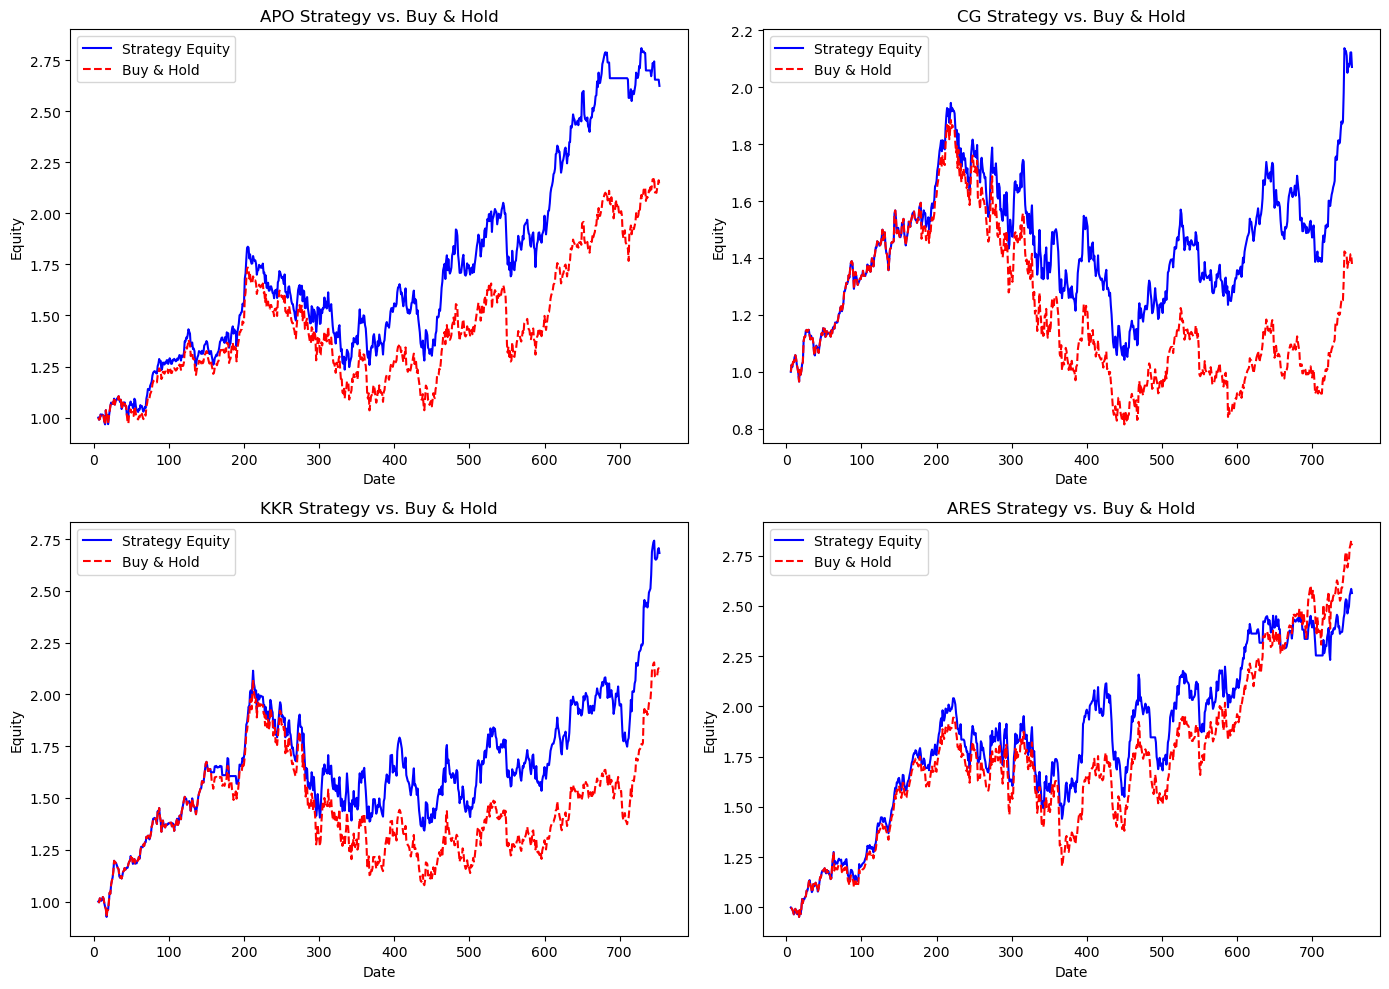

In [ ]:
def backtest_combined_model(ticker, start_date, end_date, lstm_model, rf_model, scaler, feature_columns, macro, lookback=5):
    data = yf.download(ticker, start=start_date, end=end_date)
    data["RSI"] = RSI(data, period=14)
    data = MACD(data, short_period=7, long_period=17, signal_period=9)
    data = Bollinger_Bands(data, period=20, std_multiplier=2)
    data.reset_index(drop=True, inplace=True)
    data.index = data.index + 1
    data_clean = data.copy()
    data_clean.columns = data_clean.columns.droplevel(1)
    data_final = data_clean.join(macro)
    
    data_clean_features = data_final[feature_columns].copy()
    data_clean_features[feature_columns] = scaler.transform(data_clean_features[feature_columns])
    

    X_seq = []
    for i in range(len(data_clean_features) - lookback):
        X_seq.append(data_clean_features[feature_columns].values[i:i+lookback])
    X_seq = np.array(X_seq)
    
    lstm_probs = lstm_model.predict(X_seq)  
    
    X_original = data_clean_features[feature_columns].iloc[lookback:].values
    
    X_combined = np.hstack([X_original, lstm_probs])
    
    predicted_labels = rf_model.predict(X_combined)
    
    data_final = data_final.iloc[lookback:].copy()
    data_final["Predicted Signal"] = predicted_labels
    
    return data_final

def calculate_equity_trade_backtest(df):
    df = df.copy()
    df["Position"] = np.nan
    df.loc[df["Predicted Signal"] == 2, "Position"] = 1
    df.loc[df["Predicted Signal"] == 0, "Position"] = 0
    df.loc[df["Predicted Signal"] == 1, "Position"] = df["Position"].shift(1)
    df["Position"] = df["Position"].ffill().fillna(0).astype(int)
    df["daily_return"] = df["Close"].pct_change().fillna(0)
    df["strategy_return"] = df["daily_return"] * df["Position"].shift(1).fillna(0)
    df["strategy_return"] = np.clip(df["strategy_return"], -0.05, 0.10)
    df["strategy_equity"] = (1 + df["strategy_return"]).cumprod()
    df["buy_hold_equity"] = (1 + df["daily_return"]).cumprod().fillna(1)
    return df

stocks = ["APO", "CG", "KKR", "ARES"]
start_date = "2021-01-01"
end_date = "2024-01-01"
equity_curves = {}

for stock in stocks:
    print(f"Running backtest for {stock}...")
    backtest_results = backtest_combined_model(
        stock, start_date, end_date, 
        model,  
        rf,      
        scaler, 
        feature_columns, 
        macro
    )
    backtest_results = calculate_equity_trade_backtest(backtest_results)
    equity_curves[stock] = {
        "strategy": backtest_results["strategy_equity"],
        "buy_hold": backtest_results["buy_hold_equity"],
        "dates": backtest_results.index
    }

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, stock in enumerate(stocks):
    ax = axes[i]
    ax.plot(equity_curves[stock]["dates"], equity_curves[stock]["strategy"], label="Strategy Equity", color="blue")
    ax.plot(equity_curves[stock]["dates"], equity_curves[stock]["buy_hold"], label="Buy & Hold", color="red", linestyle="dashed")
    ax.set_title(f"{stock} Strategy vs. Buy & Hold")
    ax.set_xlabel("Date")
    ax.set_ylabel("Equity")
    ax.legend()

plt.tight_layout()
plt.show()

3) PORTFOLIO OPTIMIZATION / RISK MANAGEMENT

In [22]:
import pandas as pd

strategy_returns = pd.DataFrame()
investment_stocks = ["APO", "CG","KKR", "ARES"]
for stock in investment_stocks: 
    equity = equity_curves[stock]["strategy"]
    returns = equity.pct_change().fillna(0)
    strategy_returns[stock] = returns
expected_returns = strategy_returns.mean()
cov_matrix = strategy_returns.cov()

In [23]:
import cvxpy as cp
import numpy as np

n = len(investment_stocks)
w = cp.Variable(n)
ret = expected_returns.values
cov = cov_matrix.values

objective = cp.Minimize(cp.quad_form(w, cov))  # minimize variance
constraints = [
    cp.sum(w) == 1,
    w >= 0  # Optional: long-only portfolio
]

prob = cp.Problem(objective, constraints)
prob.solve()

optimal_weights = w.value
optimal_weights[np.abs(optimal_weights) < 1e-8] = 0
portfolio_returns = strategy_returns.dot(optimal_weights)
portfolio_equity = (1 + portfolio_returns).cumprod()

In [24]:
optimal_weights

array([0.35873905, 0.1458243 , 0.06066776, 0.43476888])

In [25]:
strategy_returns.corr()


,APO,CG,KKR,ARES
APO,1.000000,0.671987,0.720998,0.682625
CG,0.671987,1.000000,0.788875,0.701789
KKR,0.720998,0.788875,1.000000,0.724058
ARES,0.682625,0.701789,0.724058,1.000000


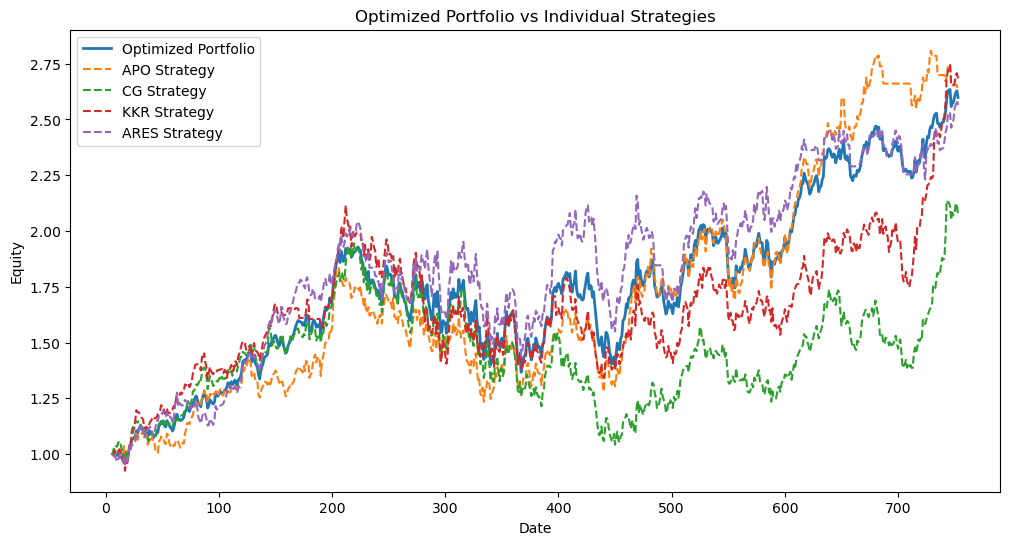

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(strategy_returns.index, portfolio_equity, label="Optimized Portfolio", linewidth=2)

for stock in investment_stocks:
    plt.plot(equity_curves[stock]["dates"], equity_curves[stock]["strategy"], label=f"{stock} Strategy", linestyle="--")

plt.title("Optimized Portfolio vs Individual Strategies")
plt.xlabel("Date")
plt.ylabel("Equity")
plt.legend()
plt.show()